Saved image stats to: outputs\image_stats.csv

=== Counts per split & class ===


class     im_Dyskeratotic  im_Koilocytotic  im_Metaplastic  im_Parabasal  \
split                                                                      
Test                  100              100             100           100   
Training              713              725             693           687   

class     im_Superficial-Intermediate  
split                                  
Test                              100  
Training                          731


--- Split: Training ---
Total images: 3549
Min width : 70 px  (file: 019_05.bmp)
Max width : 531 px  (file: 035_05.bmp)
Min height: 67 px (file: 002_07.bmp)
Max height: 553 px (file: 026_04.bmp)
Min area  : 5460 px^2 (file: 105_24.bmp)
Max area  : 232260 px^2 (file: 020_10.bmp)

--- Split: Test ---
Total images: 500
Min width : 62 px  (file: 037_03.bmp)
Max width : 378 px  (file: 024_03.bmp)
Min height: 48 px (file: 114_05.bmp)
Max height: 372 px (file: 106_07.bmp)
Min area  : 4189 px^2 (file: 217_06.bmp)
Max area  : 79060 px^2 (file: 111_02.bmp)
Saved outputs\area_hist_Training.png


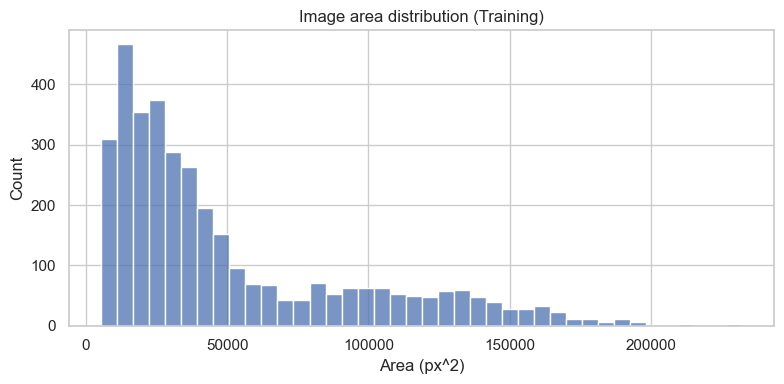

Saved outputs\area_hist_Test.png


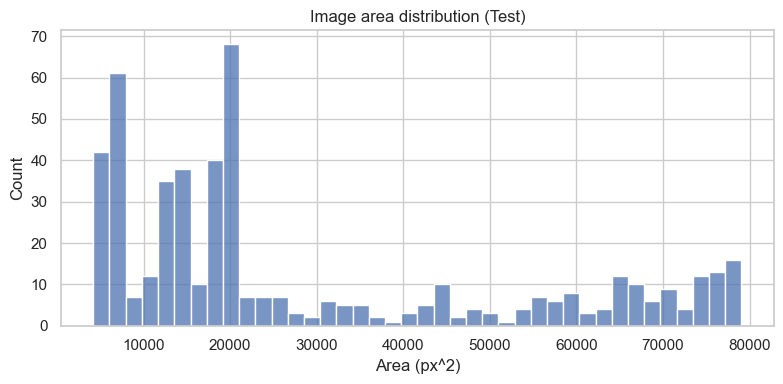

Saved example grid: outputs\examples_Training.png


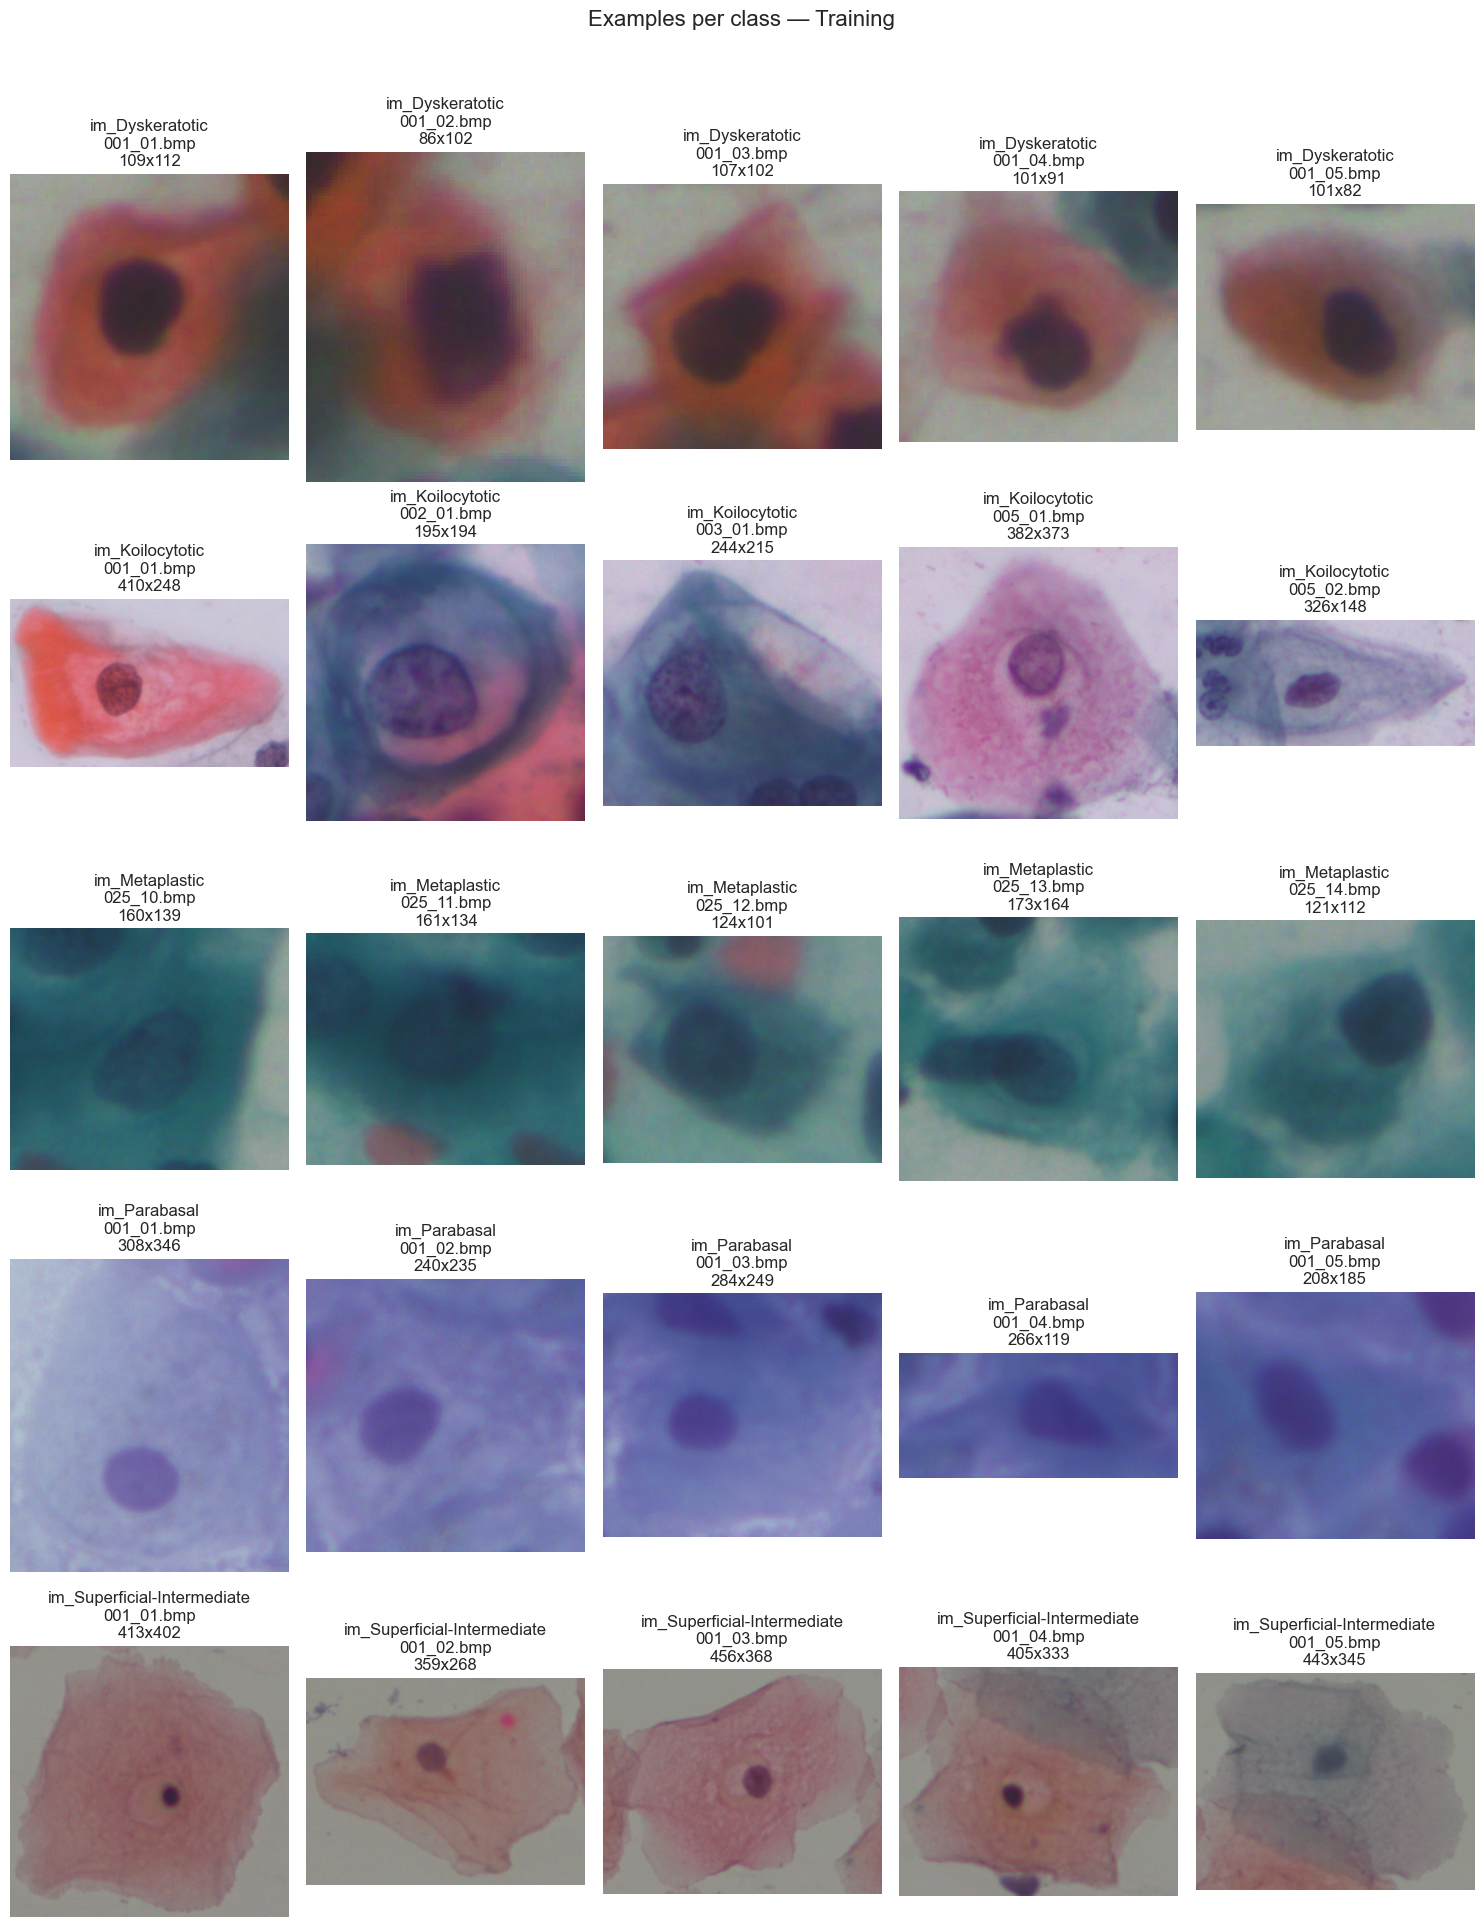

Saved example grid: outputs\examples_Test.png


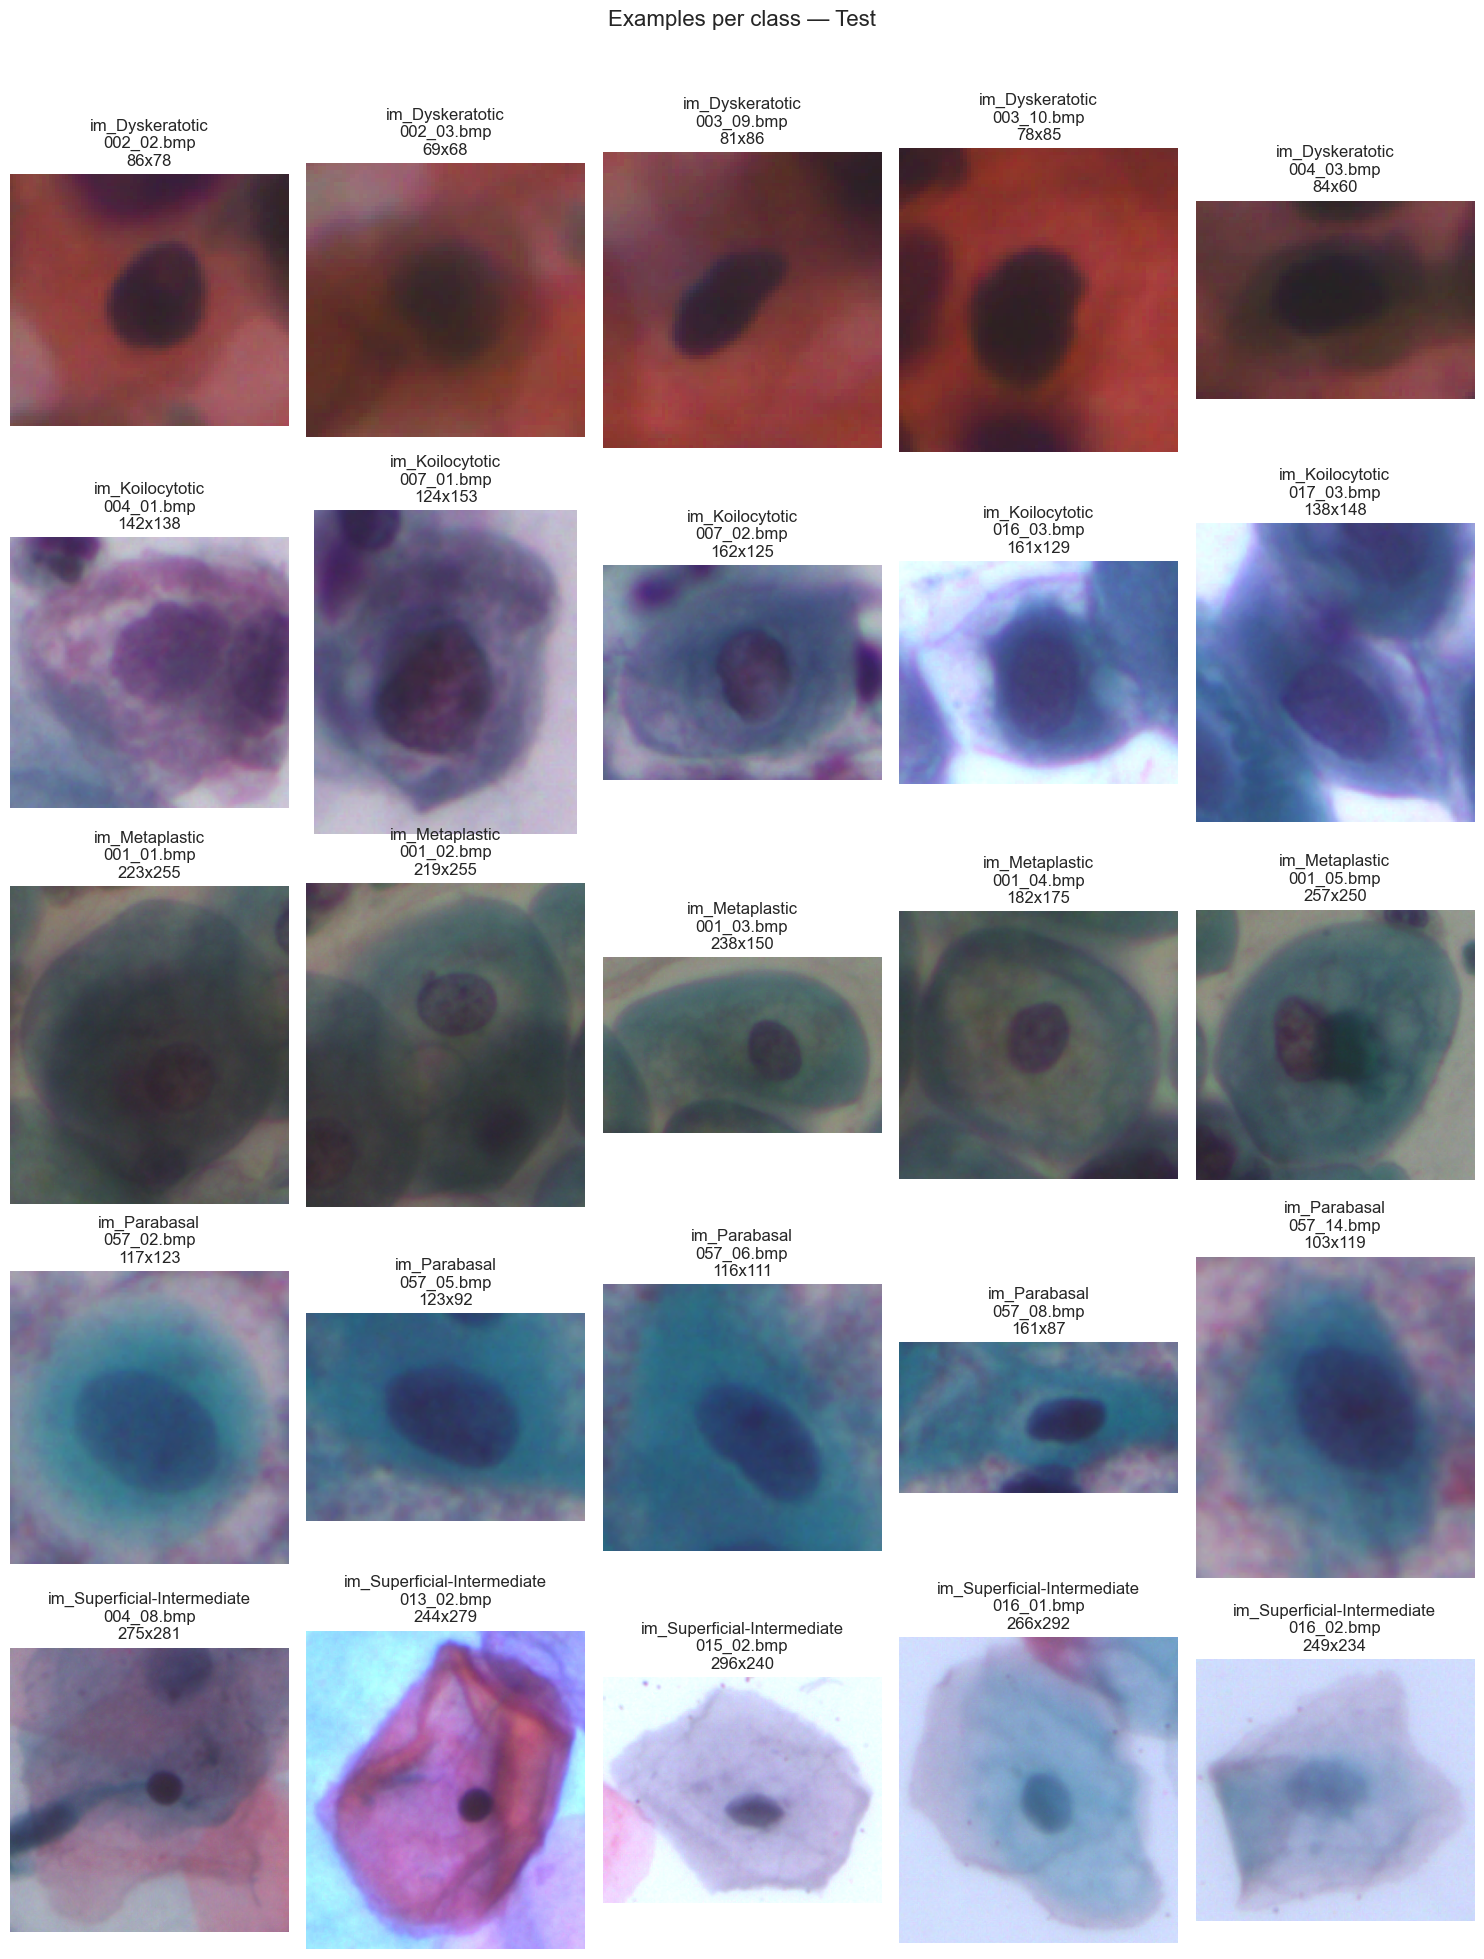


Saved summary_per_split.csv and counts_per_class.csv to outputs

Done. Check the outputs folder for CSVs and saved figures.


In [ ]:
import os
from pathlib import Path
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

DATA_ROOT = '/kaggle/input/cervical-cancer-largest-dataset-sipakmed'
NUM_EXAMPLES_PER_CLASS = 4
OUTPUT_DIR = Path("./outputs")
IMAGE_EXTS = {".bmp", ".png", ".jpg", ".jpeg", ".tiff", ".webp"}

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def is_image_file(p: Path):
    return p.suffix.lower() in IMAGE_EXTS

def load_data(data_root: Path = DATA_ROOT):
    records = []
    
    # Collect all CROPPED folders
    cropped_paths = []
    
    for path in os.listdir(data_root):
        for p in os.listdir(os.path.join(data_root, path)):
            p = os.path.join(data_root, path, p, "CROPPED")
            cropped_paths.append(p)
    cropped_paths = sorted(cropped_paths)

    if not cropped_paths:
        print(f"Warning: No CROPPED folders found under {data_root}")
        return []
    
    # Process each CROPPED folder
    cropped_paths = sorted(cropped_paths)
    for cropped_folder in cropped_paths:
        image_files = sorted([
            f for f in os.listdir(cropped_folder) 
            if is_image_file(Path(f))
        ])
        cell_class = os.path.basename(os.path.dirname(cropped_folder))[3:]
        for img_file in tqdm(image_files, desc=f"Processing {cell_class}"):
            img_path = os.path.join(cropped_folder, img_file)
            try:
                with Image.open(img_path) as im:
                    w, h = im.size
                records.append({
                    "class": cell_class,
                    "filepath": str(img_path),
                    "width": w,
                    "height": h
                })
            except Exception as e:
                print(f"Warning: cannot open {img_path}: {e}")
                continue
    
    return records

# Load data
print("Loading dataset...")
records = load_data()

if not records:
    raise RuntimeError(f"No images found under {DATA_ROOT}. Check paths.")

# Create DataFrame
df = pd.DataFrame(records)

# =================
# Print summary stats
# =================
print("\n=== Dataset Statistics ===")
print(f"Total images: {len(df)}")
print(f"\nImages per class:")
class_counts = df['class'].value_counts().sort_index()
print(class_counts)

print("\n=== Image Size Statistics ===")
minw = df.loc[df['width'].idxmin()]
maxw = df.loc[df['width'].idxmax()]
minh = df.loc[df['height'].idxmin()]
maxh = df.loc[df['height'].idxmax()]

print(f"Min width : {minw['width']} px  (file: {Path(minw['filepath']).name})")
print(f"Max width : {maxw['width']} px  (file: {Path(maxw['filepath']).name})")
print(f"Min height: {minh['height']} px (file: {Path(minh['filepath']).name})")
print(f"Max height: {maxh['height']} px (file: {Path(maxh['filepath']).name})")

# =================
# Visualize example images per class
# =================
def visualize_examples(df: pd.DataFrame, num_examples: int, output_dir: Path):
    classes = sorted(df['class'].unique())
    n_classes = len(classes)
    cols = num_examples
    
    fig_width = min(20, cols * 3)
    fig_height = max(3 * n_classes, 4 * n_classes)
    fig, axes = plt.subplots(n_classes, cols, figsize=(fig_width, fig_height))
    
    if n_classes == 1:
        axes = np.expand_dims(axes, 0)
    
    for i, cell_class in enumerate(classes):
        class_df = df[df['class'] == cell_class]
        filepaths = class_df['filepath'].values
        chosen = filepaths[:num_examples]
        
        for j in range(cols):
            ax = axes[i, j] if n_classes > 1 else axes[0, j]
            ax.axis('off')
            
            if j < len(chosen):
                try:
                    with Image.open(chosen[j]) as im:
                        
                        arr = np.array(im)
                        if arr.ndim == 2:
                            ax.imshow(arr, cmap='gray', aspect='equal')
                        else:
                            ax.imshow(arr, aspect='equal')
                        
                        img_name = Path(chosen[j]).name
                        ax.set_title(f"{cell_class}\n{img_name}\n{arr.shape[1]}x{arr.shape[0]}")
                except Exception as e:
                    ax.text(0.5, 0.5, f"Cannot open\n{Path(chosen[j]).name}", 
                           ha='center', va='center')
            else:
                ax.set_facecolor((0.95, 0.95, 0.95))
    
    plt.suptitle(f"Example images per class (top {num_examples})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    outpath = output_dir / "examples_per_class.png"
    plt.savefig(outpath, dpi=150, bbox_inches='tight')
    print(f"Saved example grid: {outpath}")
    plt.close()

visualize_examples(df, NUM_EXAMPLES_PER_CLASS, OUTPUT_DIR)

# =================
# Save aggregated CSVs
# =================
per_class = df.groupby('class').agg(
    total_images=('filepath', 'count'),
    min_width=('width', 'min'),
    max_width=('width', 'max'),
    min_height=('height', 'min'),
    max_height=('height', 'max'),
    mean_width=('width', 'mean'),
    mean_height=('height', 'mean'),
).reset_index()

df = per_class.copy()

sns.set_style("whitegrid")
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# 1. Total images per class
ax1 = plt.subplot(2, 2, 1)
colors = sns.color_palette("husl", len(df))
bars1 = ax1.bar(df['class'], df['total_images'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_title("Total Images per Class", fontsize=13, fontweight='bold')
ax1.set_ylabel("Number of Images")
ax1.tick_params(axis='x', rotation=45)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# 2. Mean dimensions comparison
ax2 = plt.subplot(2, 2, 2)
x = np.arange(len(df))
width = 0.25
bars_w = ax2.bar(x - width, df['mean_width'], width, label='Mean Width', alpha=0.8)
bars_h = ax2.bar(x, df['mean_height'], width, label='Mean Height', alpha=0.8)
ax2.set_title("Mean Width & Height per Class", fontsize=13, fontweight='bold')
ax2.set_ylabel("Pixels")
ax2.set_xticks(x)
ax2.set_xticklabels(df['class'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Width range per class
ax4 = plt.subplot(2, 2, 3)
for i, row in df.iterrows():
    ax4.plot([row['min_width'], row['max_width']], [i, i], 'o-', linewidth=3, markersize=8, color=colors[i], label=row['class'])
    ax4.text(row['mean_width'], i, f"  {row['mean_width']:.0f}", va='center', fontweight='bold', fontsize=9)
ax4.set_yticks(range(len(df)))
ax4.set_yticklabels(df['class'])
ax4.set_xlabel("Width (pixels)")
ax4.set_title("Width Range per Class", fontsize=13, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# 4. Height range per class
ax5 = plt.subplot(2, 2, 4)
for i, row in df.iterrows():
    ax5.plot([row['min_height'], row['max_height']], [i, i], 's-', linewidth=3, markersize=8, color=colors[i], label=row['class'])
    ax5.text(row['mean_height'], i, f"  {row['mean_height']:.0f}", va='center', fontweight='bold', fontsize=9)
ax5.set_yticks(range(len(df)))
ax5.set_yticklabels(df['class'])
ax5.set_xlabel("Height (pixels)")
ax5.set_title("Height Range per Class", fontsize=13, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

plt.suptitle("Dataset Statistics Summary by Class", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig("summary_statistics.png", dpi=150, bbox_inches='tight')
print("Saved: summary_statistics.png")
plt.show()
